In [5]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [6]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [7]:
# Save the input and target variables
#print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']


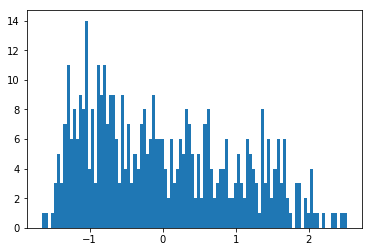

In [8]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) / targets.std()
targets


import matplotlib.pyplot as plt

plt.hist(targets, bins=100)
plt.show()

In [9]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [10]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    return model

model = get_model()

In [11]:
# Print the model summary

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [13]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [14]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15, batch_size=64, verbose=False)


In [15]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.8877 - mae: 0.7000


[0.8064389811621772, 0.70004344]

#### Plot the learning curves

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

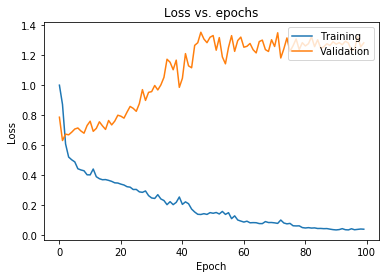

In [17]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [18]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [35]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [36]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [37]:
# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [38]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)

In [41]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5661 - mae: 0.6496


[0.5519505249129402, 0.6496318]

#### Plot the learning curves

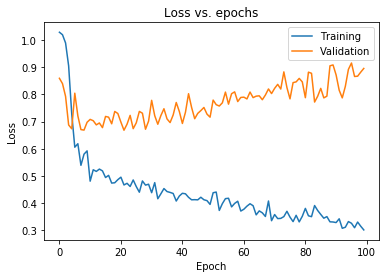

In [42]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [52]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_being(self, logs=None):
        print("Starting training ....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Finished training!")

        
class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing ....")
                
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")
                
    def on_test_end(self, logs=None):
        print("Finished testing!")
        
class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting predicting ....")
                
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Predicting: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Predicting: Finished batch {batch}")
                
    def on_predict_end(self, logs=None):
        print("Finished predicting!")

In [50]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [46]:
# Compile the model

model.compile(optimizer="adam", loss="mse")

#### Train the model with the callback

In [47]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False,
         callbacks=[TrainingCallback()])


Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training!


In [49]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False, 
               callbacks=[TestingCallback()])

Starting testing ....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


0.9767315056588914

In [53]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting predicting ....
Predicting: Starting batch 0
Predicting: Finished batch 0
Predicting: Starting batch 1
Predicting: Finished batch 1
Finished predicting!


array([[ 9.8365056e-04],
       [ 3.2549497e-04],
       [ 2.2079621e-03],
       [-1.4484263e-03],
       [ 2.1210692e-03],
       [-1.3339196e-03],
       [-3.4208621e-03],
       [ 3.1449564e-03],
       [-6.9515940e-05],
       [ 2.7843460e-04],
       [-1.0363287e-03],
       [-3.7680056e-05],
       [ 2.5481847e-04],
       [ 2.7134444e-04],
       [ 9.5142017e-04],
       [-9.4600295e-04],
       [-1.2026919e-03],
       [ 3.1469022e-03],
       [ 3.1905813e-04],
       [-1.6109322e-03],
       [-4.8396350e-03],
       [-1.0888104e-03],
       [ 1.6579370e-03],
       [-7.5410568e-04],
       [-1.2772705e-03],
       [ 1.7818544e-04],
       [-7.7997387e-04],
       [ 2.2887692e-03],
       [ 2.2447216e-03],
       [ 2.8256868e-04],
       [-1.1147959e-03],
       [ 4.4629327e-04],
       [ 9.0858690e-04],
       [ 2.2981435e-03],
       [ 1.3384800e-03],
       [ 1.1993501e-06],
       [ 1.1800396e-03],
       [-5.5043283e-04],
       [ 2.0531768e-03],
       [-5.4746325e-04],


***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [73]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer="adam", loss="mse")
unreg_history = unregularised_model.fit(train_data, train_targets, epochs=100,
                                       validation_split=0.15, batch_size=64, verbose=False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


In [74]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5765


0.5344930450121562

In [75]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer="adam", loss="mse")
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,
                                       validation_split=0.15, batch_size=64, verbose=False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


In [76]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5615


0.5544522987471686

#### Plot the learning curves

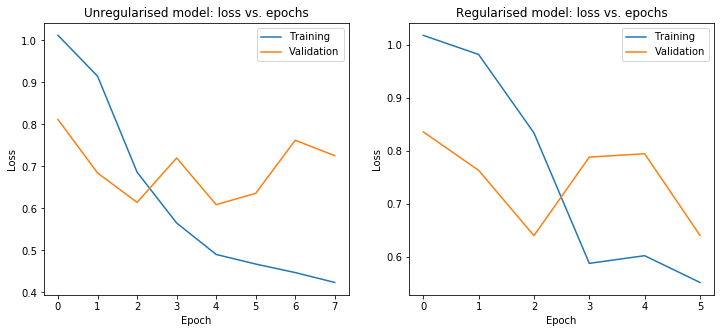

In [77]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()